In [ ]:
import importlib.util
import pip

def check_and_install(package):
    try:
        spec = importlib.util.find_spec(package)
        if spec is None:
            print(f"Installing {package}...")
            pip.main(['install', package])
    except Exception as e:
        print(f"Error installing {package}: {e}")

check_and_install('pyfinance')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from pyfinance.options import BSM
import glob


data = pd.read_csv("firma_data_better.csv", parse_dates=["Date"])

print(data.head())
print(data.columns)

        Date  Underlying  C445   C450   C455  C460   C465   C470   C475  \
0 2025-09-11      470.73   NaN    NaN    NaN  25.4  19.27  18.20  15.97   
1 2025-09-12      471.31   NaN  31.79  27.75  25.0  19.10    NaN  15.68   
2 2025-09-15      473.25   NaN    NaN    NaN   NaN    NaN  18.90  16.00   
3 2025-09-16      474.32   NaN    NaN    NaN   NaN  22.36  21.39  18.10   
4 2025-09-17      473.12   NaN    NaN    NaN  25.6    NaN  19.35    NaN   

    C480  ...   P475  P480  P485  P490  P495  P500  P505  P510  P515  P520  
0    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1  14.28  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2  13.90  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3  15.70  ...  14.25   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 34 columns]
Index(['Date', 'Underlying', 'C445', 'C450', 'C455', 'C460', 'C4

In [ ]:
# --- Find ATM call column at t0 ---

call_cols = [c for c in data.columns if c.startswith("C")]
strikes = np.array([int(c[1:]) for c in call_cols])  

S0 = data["Underlying"].iloc[0]
idx_atm = np.argmin(np.abs(strikes - S0))
K = strikes[idx_atm]
atm_col = call_cols[idx_atm]

print(f"Initial spot S0 = {S0:.2f}")
print(f"Using ATM call column {atm_col} with strike K = {K}")

# --- Build time series for that call and underlying ---
data[atm_col] = data[atm_col].interpolate() #Fill small gaps. Change if not wanted
df_hedge = (
    data[["Date", "Underlying", atm_col]]
    .dropna()
    .reset_index(drop=True)
    .rename(columns={"Underlying": "S", atm_col: "C"})
)

print(df_hedge.head())
print(f"Number of trading days in series: {len(df_hedge)}")

Initial spot S0 = 470.73
Using ATM call column C470 with strike K = 470
        Date       S      C
0 2025-09-11  470.73  18.20
1 2025-09-12  471.31  18.55
2 2025-09-15  473.25  18.90
3 2025-09-16  474.32  21.39
4 2025-09-17  473.12  19.35
Number of trading days in series: 37


In [3]:
n = len(df_hedge)
dt = 1.0 / 252.0  # 252 trading days in a year

# Time to maturity (in years) for each observation, last day T=0
T = (n - 1 - np.arange(n)) * dt
df_hedge["T"] = T

df_hedge.head()

,Date,S,C,T
0,2025-09-11,470.73,18.20,0.142857
1,2025-09-12,471.31,18.55,0.138889
2,2025-09-15,473.25,18.90,0.134921
3,2025-09-16,474.32,21.39,0.130952
4,2025-09-17,473.12,19.35,0.126984


In [4]:
# Risk-free rate (can be changed)
r = 0.0

S0 = df_hedge.loc[0, "S"]
C0 = df_hedge.loc[0, "C"]
T0 = df_hedge.loc[0, "T"]

print(f"T0 (years) = {T0:.4f} (~{T0*252:.1f} trading days to maturity)")

# Initial guess for sigma (doesn't matter much, implied_vol does root-finding)
sigma_guess = 0.2

op0 = BSM(kind='call', S0=S0, K=K, T=T0, r=r, sigma=sigma_guess)
sigma0 = op0.implied_vol(value=C0)

print(f"Implied volatility at t0: sigma0 = {sigma0:.4f}")

T0 (years) = 0.1429 (~36.0 trading days to maturity)
Implied volatility at t0: sigma0 = 0.2515


In [ ]:
def simulate_delta_hedge(
    S, C, T, K, r, sigma0,
    rebalance_every=1,
    cost_rate=0.0,
    use_implied_vol=False,
):
    """
    Delta hedging simulation with optional time-varying implied volatility.

    Parameters
    ----------
    S, C, T : 1D numpy arrays of same length n
    K, r, sigma0 
    rebalance_every : int
    cost_rate : float
    use_implied_vol : bool
    """

    S = np.asarray(S)
    C = np.asarray(C)
    T = np.asarray(T)
    n = len(S)

    # Storage
    deltas = np.zeros(n)
    A_no_cost = np.zeros(n - 1)
    A_with_cost = np.zeros(n - 1)
    costs = np.zeros(n - 1)        # cost incurred at start of each period i
    sigma_used = np.zeros(n)       # volatility actually used at each step

    current_delta = 0.0            # start flat in underlying
    sigma_current = sigma0         # start with given sigma

    for i in range(n - 1):
        # Decide whether to rebalance at start of period [i, i+1]
        if i == 0 or (i % rebalance_every == 0):

            # Optionally update sigma_current using implied vol from C[i]
            if use_implied_vol and T[i] > 0 and C[i] > 0 and S[i] > 0:
                try:
                    op_iv = BSM(
                        kind="call",
                        S0=S[i],
                        K=K,
                        T=T[i],
                        r=r,
                        sigma=max(1e-4, sigma_current)  # initial guess
                    )
                    sigma_iv = op_iv.implied_vol(value=C[i])
                    # Only accept "reasonable" numbers
                    if np.isfinite(sigma_iv) and sigma_iv > 0:
                        sigma_current = sigma_iv
                except Exception:
                    # If implied vol fails, keep previous sigma_current
                    pass

            # Compute new delta at time i using sigma_current
            if T[i] <= 0:
                # At/after maturity: delta = 1 if ITM, else 0
                new_delta = 1.0 if S[i] > K else 0.0
            else:
                op = BSM(kind="call", S0=S[i], K=K, T=T[i], r=r, sigma=sigma_current)
                new_delta = op.delta()

            traded = abs(new_delta - current_delta)
            costs[i] = cost_rate * traded * S[i]     # proportional cost
            current_delta = new_delta

        deltas[i] = current_delta
        sigma_used[i] = sigma_current

        # Changes in option and spot over [i, i+1]
        dC = C[i + 1] - C[i]
        dS = S[i + 1] - S[i]

        # Hedging error without transaction costs
        A_no_cost[i] = dC - current_delta * dS

        # Hedging error including the transaction cost at time i
        A_with_cost[i] = A_no_cost[i] - costs[i]

    # Hold the last delta and sigma constant to expiry (for information)
    deltas[-1] = current_delta
    sigma_used[-1] = sigma_current

    # Mean squared errors
    E_no_cost = np.mean(A_no_cost**2)
    E_with_cost = np.mean(A_with_cost**2)

    # Cumulative tracking error curves (for plotting P&L of hedged portfolio)
    cum_error_no_cost = np.cumsum(A_no_cost)
    cum_error_with_cost = np.cumsum(A_with_cost)

    result = {
        "deltas": deltas,
        "A_no_cost": A_no_cost,
        "A_with_cost": A_with_cost,
        "E_no_cost": E_no_cost,
        "E_with_cost": E_with_cost,
        "costs": costs,
        "total_cost": float(np.sum(costs)),
        "cum_error_no_cost": cum_error_no_cost,
        "cum_error_with_cost": cum_error_with_cost,
        "sigma_used": sigma_used,
    }
    return result


In [6]:
S = df_hedge["S"].values
C = df_hedge["C"].values
T = df_hedge["T"].values


freqs = [1, 2, 5, 10]   # hedge daily, every 2 days, 5 days, 10 days
cost_rate = 0.05        # 5% transaction cost per notional traded

results = {}

for f in freqs:
    res = simulate_delta_hedge(S, C, T, K, r, sigma0,
                               rebalance_every=f,
                               cost_rate=cost_rate,
                               use_implied_vol=True)
    results[f] = res
    print(f"=== Rebalance every {f} day(s) ===")
    print(f"  MSE without costs: {res['E_no_cost']:.6e}")
    print(f"  MSE with costs:    {res['E_with_cost']:.6e}")
    print(f"  Total transaction cost: {res['total_cost']:.4f}")
    print()


=== Rebalance every 1 day(s) ===
  MSE without costs: 1.499856e+01
  MSE with costs:    2.408039e+01
  Total transaction cost: 58.0128

=== Rebalance every 2 day(s) ===
  MSE without costs: 1.416472e+01
  MSE with costs:    2.070380e+01
  Total transaction cost: 29.3482

=== Rebalance every 5 day(s) ===
  MSE without costs: 1.328635e+01
  MSE with costs:    1.894177e+01
  Total transaction cost: 22.3703

=== Rebalance every 10 day(s) ===
  MSE without costs: 1.395589e+01
  MSE with costs:    1.898490e+01
  Total transaction cost: 19.9149



/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (


In [7]:
# Summarizing current delta-hedge runs into a table

summary_rows = []
for f in freqs:
    res = results[f]
    summary_rows.append({
        "rebalance_every": f,
        "E_no_cost": res["E_no_cost"],
        "E_with_cost": res["E_with_cost"],
        "total_cost": res["total_cost"],
    })

df_delta_summary = pd.DataFrame(summary_rows).sort_values("rebalance_every")
print(df_delta_summary)

   rebalance_every  E_no_cost  E_with_cost  total_cost
0                1  14.998557    24.080386   58.012755
1                2  14.164725    20.703796   29.348191
2                5  13.286354    18.941774   22.370277
3               10  13.955892    18.984903   19.914947


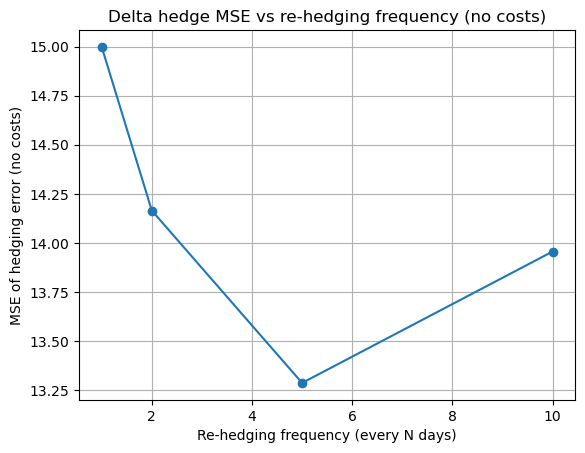

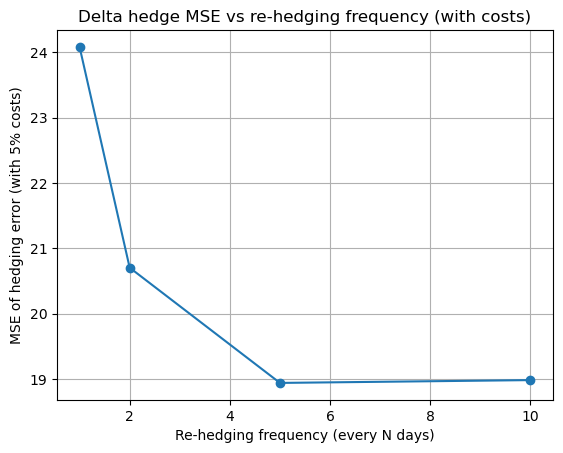

In [8]:
# Plot MSE without costs vs frequency
plt.figure()
plt.plot(df_delta_summary["rebalance_every"], df_delta_summary["E_no_cost"], marker="o")
plt.xlabel("Re-hedging frequency (every N days)")
plt.ylabel("MSE of hedging error (no costs)")
plt.title("Delta hedge MSE vs re-hedging frequency (no costs)")
plt.grid(True)
plt.show()

# Plot MSE with costs vs frequency
plt.figure()
plt.plot(df_delta_summary["rebalance_every"], df_delta_summary["E_with_cost"], marker="o")
plt.xlabel("Re-hedging frequency (every N days)")
plt.ylabel("MSE of hedging error (with 5% costs)")
plt.title("Delta hedge MSE vs re-hedging frequency (with costs)")
plt.grid(True)
plt.show()

In [ ]:
def call_greeks(S, K, T, r, sigma):
    """
    Return (delta, vega) for a European call 
    """
    if T <= 0 or S <= 0 or K <= 0:
        # At expiry, Delta is 1{S > K}, Vega is 0
        delta = 1.0 if S > K else 0.0
        vega = 0.0
    else:
        op = BSM(kind='call', S0=S, K=K, T=T, r=r, sigma=sigma)
        delta = op.delta()
        vega = op.vega()
    return delta, vega


In [ ]:
def call_greeks_dg(S, K, T, r, sigma):
    """
    Return (delta, gamma) for a European call
    """
    if T <= 0 or S <= 0 or K <= 0:
        # At expiry: delta = 1{S > K}, gamma = 0
        delta = 1.0 if S > K else 0.0
        gamma = 0.0
    else:
        op = BSM(kind="call", S0=S, K=K, T=T, r=r, sigma=sigma)
        delta = op.delta()
        gamma = op.gamma()
    return delta, gamma


In [ ]:
# --- Define the longer-maturity replicating option T2 ---

# Original time-to-maturity at t0 
T0 = df_hedge.loc[0, "T"]          # e.g. ~45/252 for 45 trading days
# Choose a longer maturity, e.g. +60 trading days.
extra_days = 60
extra_T = extra_days / 252.0
T2_0 = T0 + extra_T                # maturity of the replicating call at t0

print(f"Original maturity T0  (years): {T0:.4f} (~{T0*252:.1f} trading days)")
print(f"Replicating maturity T2 (years): {T2_0:.4f} (~{T2_0*252:.1f} trading days)")

# Time grid for original option (T[i]) is already defined:
S = df_hedge["S"].values
C = df_hedge["C"].values
T = df_hedge["T"].values
dates = df_hedge["Date"].values
n = len(S)

# Time-to-maturity of replicating option at each date:
# keep a constant gap (T2_0 - T0)
T_rep = T + (T2_0 - T0)


print(f"Using constant volatility sigma0 = {sigma0:.4f} for both original and replicating calls.")


# --- Simulation of delta–vega hedging ---

def simulate_delta_vega_hedge(
    S, C, T, T_rep, K, r, sigma,
    rebalance_every=1,
    cost_rate=0.0
):
    """
    Delta–vega hedging simulation.

    Inputs:
      S, C:       arrays of underlying and original call prices (len n)
      T:          time to maturity of original option at each date
      T_rep:      time to maturity of replicating option at each date
      K, r, sigma: strike, rate, volatility
      rebalance_every: rebalance hedge every k days
      cost_rate:  proportional transaction cost on stock and replicating
    """

    S = np.asarray(S)
    C = np.asarray(C)
    T = np.asarray(T)
    T_rep = np.asarray(T_rep)

    n = len(S)

    alpha = np.zeros(n)  # position in underlying
    eta = np.zeros(n)    # position in replicating call

    # For error tracking
    A_no_cost = np.zeros(n - 1)
    A_with_cost = np.zeros(n - 1)

    # Transaction costs per step: we allow costs on stock and replicating option trades
    costs = np.zeros(n - 1)

    # Keep track of old positions to compute traded amounts
    alpha_old = 0.0
    eta_old = 0.0

    # Also track the replicating option price series (model-based)
    C_rep = np.zeros(n)

    for i in range(n):
        # Price of replicating call at time i (model value)
        if T_rep[i] <= 0:
            C_rep[i] = max(S[i] - K, 0.0)
        else:
            op_rep_i = BSM(kind='call', S0=S[i], K=K, T=T_rep[i], r=r, sigma=sigma)
            C_rep[i] = op_rep_i.value()

    # Now walk forward in time between i and i+1
    for i in range(n - 1):

        # Compute hedging ratios at rebalance times
        if i == 0 or (i % rebalance_every == 0):
            # Greeks of original option (to be hedged)
            Delta_BS, Vega_BS = call_greeks(S[i], K, T[i], r, sigma)

            # Greeks of replicating option
            Delta_rep, Vega_rep = call_greeks(S[i], K, T_rep[i], r, sigma)

            # Avoid division by zero if Vega_rep is (numerically) zero
            if abs(Vega_rep) < 1e-12:
                # If no vega in replicating option, fall back to pure delta hedge
                eta_i = 0.0
                alpha_i = -Delta_BS
            else:
                eta_i = - Vega_BS / Vega_rep
                alpha_i = - Delta_BS - eta_i * Delta_rep

            # Transaction costs from changing positions
            traded_stock = abs(alpha_i - alpha_old) * S[i]
            traded_rep = abs(eta_i - eta_old) * C_rep[i]
            costs[i] = cost_rate * (traded_stock + traded_rep)

            alpha_old = alpha_i
            eta_old = eta_i

        # Store current positions
        alpha[i] = alpha_old
        eta[i] = eta_old

        # Changes over [i, i+1]
        dC = C[i + 1] - C[i]           # original option price change
        dS = S[i + 1] - S[i]           # underlying change
        dC_rep = C_rep[i + 1] - C_rep[i]

        # Change in value of replicating portfolio RE
        #   RE value V_RE = alpha * S + eta * C_rep
        #   => ΔV_RE ≈ alpha_i * dS + eta_i * dC_rep
        dV_RE = alpha[i] * dS + eta[i] * dC_rep

        # Hedging error:
        #   A_i = change in OP – change in RE
        A_no_cost[i] = dC - dV_RE

        # Including transaction costs paid at time i
        A_with_cost[i] = A_no_cost[i] - costs[i]

    # Keep last positions for completeness
    alpha[-1] = alpha_old
    eta[-1] = eta_old

    E_no_cost = np.mean(A_no_cost**2)
    E_with_cost = np.mean(A_with_cost**2)

    result = {
        "alpha": alpha,
        "eta": eta,
        "C_rep": C_rep,
        "A_no_cost": A_no_cost,
        "A_with_cost": A_with_cost,
        "E_no_cost": E_no_cost,
        "E_with_cost": E_with_cost,
        "costs": costs,
        "total_cost": float(np.sum(costs)),
    }
    return result

def simulate_delta_vega_hedge_iv(
    S, C, T, T_rep, K, r,
    sigma_init,
    rebalance_every=1,
    cost_rate=0.0
):
    """
    Delta–vega hedging with implied volatility recalibrated at re-hedging dates.

    Inputs
    ------
    S, C, T, T_rep : 1D arrays (len n)
        S[i]     : spot at time i
        C[i]     : market price of original call at time i
        T[i]     : time to maturity (years) of original call at time i
        T_rep[i] : time to maturity (years) of replicating call at time i
    K, r         : strike and risk-free rate
    sigma_init   : initial guess for implied vol at t0
    rebalance_every : rebalance every k steps 
    cost_rate    : proportional transaction cost

    """

    S = np.asarray(S)
    C = np.asarray(C)
    T = np.asarray(T)
    T_rep = np.asarray(T_rep)
    n = len(S)

    alpha = np.zeros(n)         # stock position
    eta = np.zeros(n)           # replicating call position
    sigma_used = np.zeros(n)    # sigma in use at each time
    C_rep = np.zeros(n)         # model price of replicating call

    A_no_cost = np.zeros(n - 1)
    A_with_cost = np.zeros(n - 1)
    costs = np.zeros(n - 1)

    alpha_old = 0.0
    eta_old = 0.0
    sigma_current = sigma_init

    for i in range(n - 1):

        # --- Re-hedge (and recalibrate implied vol) at selected times ---
        if i == 0 or (i % rebalance_every == 0):
            # 1) Recompute implied vol from market price C[i]
            if T[i] > 0 and C[i] > 0 and S[i] > 0:
                try:
                    op_iv = BSM(
                        kind='call',
                        S0=S[i],
                        K=K,
                        T=T[i],
                        r=r,
                        sigma=max(1e-4, sigma_current)
                    )
                    sigma_iv = op_iv.implied_vol(value=C[i])
                    if np.isfinite(sigma_iv) and sigma_iv > 0:
                        sigma_current = sigma_iv
                except Exception:
                    # If implied vol fails, keep previous sigma_current
                    pass

            # 2) Greeks of original call at sigma_current
            Delta_BS, Vega_BS = call_greeks(S[i], K, T[i], r, sigma_current)

            # 3) Greeks of replicating call at sigma_current
            Delta_rep, Vega_rep = call_greeks(S[i], K, T_rep[i], r, sigma_current)

            # 4) Compute hedging ratios alpha, eta
            if abs(Vega_rep) < 1e-12:
                # Fallback: no vega in replicating option -> pure delta hedge
                eta_i = 0.0
                alpha_i = -Delta_BS
            else:
                eta_i = - Vega_BS / Vega_rep
                alpha_i = - Delta_BS - eta_i * Delta_rep

            # 5) Transaction costs for changing positions
            if T_rep[i] <= 0:
                C_rep_i = max(S[i] - K, 0.0)
            else:
                op_rep_i = BSM(
                    kind='call',
                    S0=S[i],
                    K=K,
                    T=T_rep[i],
                    r=r,
                    sigma=sigma_current
                )
                C_rep_i = op_rep_i.value()

            traded_stock = abs(alpha_i - alpha_old) * S[i]
            traded_rep = abs(eta_i - eta_old) * C_rep_i
            costs[i] = cost_rate * (traded_stock + traded_rep)

            alpha_old = alpha_i
            eta_old = eta_i

        # --- Store current positions and sigma in use ---
        alpha[i] = alpha_old
        eta[i] = eta_old
        sigma_used[i] = sigma_current

        # --- Price replicating call at i and i+1 with sigma_current ---
        if T_rep[i] <= 0:
            C_rep_i = max(S[i] - K, 0.0)
        else:
            C_rep_i = BSM(
                kind='call',
                S0=S[i],
                K=K,
                T=T_rep[i],
                r=r,
                sigma=sigma_current
            ).value()

        if T_rep[i + 1] <= 0:
            C_rep_ip1 = max(S[i + 1] - K, 0.0)
        else:
            C_rep_ip1 = BSM(
                kind='call',
                S0=S[i + 1],
                K=K,
                T=T_rep[i + 1],
                r=r,
                sigma=sigma_current
            ).value()

        # Option and underlying changes over [i, i+1]
        dC = C[i + 1] - C[i]
        dS = S[i + 1] - S[i]
        dC_rep = C_rep_ip1 - C_rep_i

        # Change in replicating portfolio value:
        # V_RE = alpha * S + eta * C_rep
        dV_RE = alpha[i] * dS + eta[i] * dC_rep

        # Hedging errors
        A_no_cost[i] = dC - dV_RE
        A_with_cost[i] = A_no_cost[i] - costs[i]

        # Store replicating prices for reference
        C_rep[i] = C_rep_i
        if i == n - 2:
            C_rep[i + 1] = C_rep_ip1

    # Fill last entries
    alpha[-1] = alpha_old
    eta[-1] = eta_old
    sigma_used[-1] = sigma_current

    E_no_cost = np.mean(A_no_cost**2)
    E_with_cost = np.mean(A_with_cost**2)

    return {
        "alpha": alpha,
        "eta": eta,
        "sigma_used": sigma_used,
        "C_rep": C_rep,
        "A_no_cost": A_no_cost,
        "A_with_cost": A_with_cost,
        "E_no_cost": E_no_cost,
        "E_with_cost": E_with_cost,
        "costs": costs,
        "total_cost": float(np.sum(costs)),
    }




cost_rate_dv = 0.05     
rebalance_every_dv = 1 

res_dv = simulate_delta_vega_hedge(
    S=S,
    C=C,
    T=T,
    T_rep=T_rep,
    K=K,
    r=r,
    sigma=sigma0,
    rebalance_every=rebalance_every_dv,
    cost_rate=cost_rate_dv, 
)

print("=== Delta–vega hedge (daily rebalancing) ===")
print(f"  MSE without costs: {res_dv['E_no_cost']:.6e}")
print(f"  MSE with costs:    {res_dv['E_with_cost']:.6e}")
print(f"  Total transaction cost: {res_dv['total_cost']:.4f}")

if 1 in results:
    print("\n=== Comparison to pure delta hedge (daily) ===")
    print(f"  Delta-only MSE (no cost): {results[1]['E_no_cost']:.6e}")
    print(f"  Delta-only MSE (with cost): {results[1]['E_with_cost']:.6e}")
    print(f"  Delta-only total cost: {results[1]['total_cost']:.4f}")
    
    
cost_rate_dv = 0.05          
rebalance_every_dv = 1       

res_dv_iv = simulate_delta_vega_hedge_iv(
    S=S,
    C=C,
    T=T,
    T_rep=T_rep,
    K=K,
    r=r,
    sigma_init=sigma0,
    rebalance_every=rebalance_every_dv,
    cost_rate=cost_rate_dv
)

print("=== Delta–vega hedge with time-varying implied vol (daily) ===")
print(f"  MSE without costs: {res_dv_iv['E_no_cost']:.6e}")
print(f"  MSE with costs:    {res_dv_iv['E_with_cost']:.6e}")
print(f"  Total transaction cost: {res_dv_iv['total_cost']:.4f}")


Original maturity T0  (years): 0.1429 (~36.0 trading days)
Replicating maturity T2 (years): 0.3810 (~96.0 trading days)
Using constant volatility sigma0 = 0.2515 for both original and replicating calls.
=== Delta–vega hedge (daily rebalancing) ===
  MSE without costs: 3.970700e+01
  MSE with costs:    4.771299e+01
  Total transaction cost: 45.6042

=== Comparison to pure delta hedge (daily) ===
  Delta-only MSE (no cost): 1.499856e+01
  Delta-only MSE (with cost): 2.408039e+01
  Delta-only total cost: 58.0128
=== Delta–vega hedge with time-varying implied vol (daily) ===
  MSE without costs: 3.660819e+01
  MSE with costs:    5.167152e+01
  Total transaction cost: 69.6478


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (


In [11]:
# Delta-vega vs delta comparison table

comp_rows = []

# Pure delta, daily
comp_rows.append({
    "strategy": "Delta (daily, IV)",
    "E_no_cost": results[1]["E_no_cost"],
    "E_with_cost": results[1]["E_with_cost"],
    "total_cost": results[1]["total_cost"],
})

# Delta–vega, constant sigma
comp_rows.append({
    "strategy": "Delta–vega (daily, const σ)",
    "E_no_cost": res_dv["E_no_cost"],
    "E_with_cost": res_dv["E_with_cost"],
    "total_cost": res_dv["total_cost"],
})

# Delta–vega, time-varying IV
comp_rows.append({
    "strategy": "Delta–vega (daily, IV)",
    "E_no_cost": res_dv_iv["E_no_cost"],
    "E_with_cost": res_dv_iv["E_with_cost"],
    "total_cost": res_dv_iv["total_cost"],
})

df_compare = pd.DataFrame(comp_rows)
print(df_compare)


                      strategy  E_no_cost  E_with_cost  total_cost
0            Delta (daily, IV)  14.998557    24.080386   58.012755
1  Delta–vega (daily, const σ)  39.707005    47.712993   45.604215
2       Delta–vega (daily, IV)  36.608186    51.671523   69.647849


In [12]:
# --- Single option: delta–vega hedging for multiple re-hedging frequencies ---

freqs_dv = [1, 2, 5, 10]
cost_rate_dv = 0.05

dv_const_results = {}
dv_iv_results = {}

for f in freqs_dv:
    # Constant sigma
    dv_const_results[f] = simulate_delta_vega_hedge(
        S=S,
        C=C,
        T=T,
        T_rep=T_rep,
        K=K,
        r=r,
        sigma=sigma0,
        rebalance_every=f,
        cost_rate=cost_rate_dv,
    )
    # Time-varying implied vol
    dv_iv_results[f] = simulate_delta_vega_hedge_iv(
        S=S,
        C=C,
        T=T,
        T_rep=T_rep,
        K=K,
        r=r,
        sigma_init=sigma0,
        rebalance_every=f,
        cost_rate=cost_rate_dv,
    )

# Summaries into tables
rows_const = []
rows_iv = []

for f in freqs_dv:
    res_c = dv_const_results[f]
    res_iv = dv_iv_results[f]

    rows_const.append({
        "rebalance_every": f,
        "E_no_cost": res_c["E_no_cost"],
        "E_with_cost": res_c["E_with_cost"],
        "total_cost": res_c["total_cost"],
    })

    rows_iv.append({
        "rebalance_every": f,
        "E_no_cost": res_iv["E_no_cost"],
        "E_with_cost": res_iv["E_with_cost"],
        "total_cost": res_iv["total_cost"],
    })

df_dv_const = pd.DataFrame(rows_const).sort_values("rebalance_every")
df_dv_iv = pd.DataFrame(rows_iv).sort_values("rebalance_every")

print("Delta–vega hedge (single option), constant sigma:")
print(df_dv_const)
print("\nDelta–vega hedge (single option), time-varying implied vol:")
print(df_dv_iv)


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (


Delta–vega hedge (single option), constant sigma:
   rebalance_every  E_no_cost  E_with_cost  total_cost
0                1  39.707005    47.712993   45.604215
1                2  38.229102    36.786558   25.716058
2                5  37.051436    40.190553   29.580840
3               10  36.828372    42.935286   19.402546

Delta–vega hedge (single option), time-varying implied vol:
   rebalance_every  E_no_cost  E_with_cost  total_cost
0                1  36.608186    51.671523   69.647849
1                2  34.891085    38.092790   29.276976
2                5  32.996725    34.195726   22.366055
3               10  33.100988    36.353912   15.703521


In [ ]:

def simulate_delta_hedge_portfolio(
    S, C_mat, T, K_vec, weights,
    r, sigma0,
    rebalance_every=1,
    cost_rate=0.0,
    use_implied_vol=False,
    iv_ref_idx=1,
):
    """
    Delta hedging for an option portfolio (e.g. butterfly).

    Parameters
    ----------
    S : 1D array, shape (n,)

    C_mat : 2D array, shape (n, m)
        Matrix of option prices. Column j corresponds to strike K_vec[j].
        Example: columns = [C_low, C_mid, C_high].
    T : 1D array, shape (n,)
    K_vec : 1D array, shape (m,)
        Strikes of the options (e.g. [K1, K2, K3]).
    weights : 1D array, shape (m,)
    r : float
        Risk-free rate.
    sigma0 : float
    rebalance_every : int
    cost_rate : float
    use_implied_vol : bool

    iv_ref_idx : int

    """

    S = np.asarray(S)
    C_mat = np.asarray(C_mat)
    T = np.asarray(T)
    K_vec = np.asarray(K_vec)
    weights = np.asarray(weights)

    n, m = C_mat.shape
    assert len(S) == n and len(T) == n
    assert len(K_vec) == m and len(weights) == m

    # Portfolio prices from market 
    C_port = (C_mat * weights).sum(axis=1)

    # Storage
    deltas = np.zeros(n)          # portfolio delta
    A_no_cost = np.zeros(n - 1)
    A_with_cost = np.zeros(n - 1)
    costs = np.zeros(n - 1)
    sigma_used = np.zeros(n)

    current_delta = 0.0
    sigma_current = sigma0

    for i in range(n - 1):
        # Rehedge at start of [i, i+1]
        if i == 0 or (i % rebalance_every == 0):

            # --- 1) Optionally recalibrate implied vol from reference option ---
            if use_implied_vol and T[i] > 0 and S[i] > 0 and C_mat[i, iv_ref_idx] > 0:
                try:
                    op_iv = BSM(
                        kind="call",
                        S0=S[i],
                        K=K_vec[iv_ref_idx],
                        T=T[i],
                        r=r,
                        sigma=max(1e-4, sigma_current)  # initial guess
                    )
                    sigma_iv = op_iv.implied_vol(value=C_mat[i, iv_ref_idx])
                    if np.isfinite(sigma_iv) and sigma_iv > 0:
                        sigma_current = sigma_iv
                except Exception:
                    # If we fail to find IV, keep previous sigma_current
                    pass

            # --- 2) Compute portfolio delta = sum_j weights_j * Delta_j ---
            if T[i] <= 0:
                # At/after maturity: each call delta is 1{S > K}, so:
                deltas_i = (weights * (S[i] > K_vec).astype(float)).sum()
            else:
                deltas_i = 0.0
                for j in range(m):
                    op_j = BSM(
                        kind="call",
                        S0=S[i],
                        K=K_vec[j],
                        T=T[i],
                        r=r,
                        sigma=sigma_current
                    )
                    deltas_i += weights[j] * op_j.delta()

            new_delta = deltas_i

            # --- 3) Transaction cost from changing underlying position ---
            traded = abs(new_delta - current_delta)
            costs[i] = cost_rate * traded * S[i]

            current_delta = new_delta

        deltas[i] = current_delta
        sigma_used[i] = sigma_current

        # --- 4) Hedging error over [i, i+1] ---
        dC_port = C_port[i + 1] - C_port[i]
        dS = S[i + 1] - S[i]

        A_no_cost[i] = dC_port - current_delta * dS
        A_with_cost[i] = A_no_cost[i] - costs[i]

    # Last entries
    deltas[-1] = current_delta
    sigma_used[-1] = sigma_current

    E_no_cost = np.mean(A_no_cost**2)
    E_with_cost = np.mean(A_with_cost**2)

    cum_error_no_cost = np.cumsum(A_no_cost)
    cum_error_with_cost = np.cumsum(A_with_cost)

    return {
        "deltas": deltas,
        "A_no_cost": A_no_cost,
        "A_with_cost": A_with_cost,
        "E_no_cost": E_no_cost,
        "E_with_cost": E_with_cost,
        "costs": costs,
        "total_cost": float(np.sum(costs)),
        "cum_error_no_cost": cum_error_no_cost,
        "cum_error_with_cost": cum_error_with_cost,
        "sigma_used": sigma_used,
    }


In [ ]:

col_low  = "C460"
col_mid  = "C470"
col_high = "C480"

K_low  = int(col_low[1:])   # 460
K_mid  = int(col_mid[1:])   # 470
K_high = int(col_high[1:])  # 480

K_vec = np.array([K_low, K_mid, K_high])
weights = np.array([1.0, -2.0, 1.0])   # butterfly

# Build the time series
df_bfly = data[["Date", "Underlying", col_low, col_mid, col_high]].dropna().reset_index(drop=True)
S_b = df_bfly["Underlying"].values
C_mat_b = df_bfly[[col_low, col_mid, col_high]].values

# Time to maturity T (years)
n_b = len(df_bfly)
dt = 1.0 / 252.0
T_b = (n_b - 1 - np.arange(n_b)) * dt

# Risk-free rate & initial vol 
r = 0.0


In [ ]:
res_bfly_iv = simulate_delta_hedge_portfolio(
    S=S_b,
    C_mat=C_mat_b,
    T=T_b,
    K_vec=K_vec,
    weights=weights,
    r=r,
    sigma0=sigma0,
    rebalance_every=1,
    cost_rate=0.05,
    use_implied_vol=True,  
    iv_ref_idx=1            
)

print("\nButterfly, time-varying implied σ:")
print("  MSE (no cost):", res_bfly_iv["E_no_cost"])
print("  MSE (with cost):", res_bfly_iv["E_with_cost"])
print("  Total trading cost:", res_bfly_iv["total_cost"])


Butterfly, time-varying implied σ:
  MSE (no cost): 142.07664610496786
  MSE (with cost): 140.86170734023523
  Total trading cost: 2.0661983914076996


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (


In [ ]:
def simulate_delta_vega_hedge_portfolio_iv(
    S, C_mat, T, K_vec, weights,
    r,
    sigma_init,
    extra_days_rep=60,      # how much longer maturity for the replicating call
    rebalance_every=1,
    cost_rate=0.0,
    iv_ref_idx=1           # which strike to use for implied vol + replicating call
):
    """

    Parameters
    ----------
    S : (n,) array
    C_mat : (n, m) array
    T : (n,) array
    K_vec : (m,) array
    weights : (m,) array
    r : float
        Risk-free rate.
    sigma_init : float
    extra_days_rep : int
    rebalance_every : int
    cost_rate : float
    iv_ref_idx : int

    """

    S = np.asarray(S)
    C_mat = np.asarray(C_mat)
    T = np.asarray(T)
    K_vec = np.asarray(K_vec)
    weights = np.asarray(weights)

    n, m = C_mat.shape
    assert len(S) == n and len(T) == n
    assert len(K_vec) == m and len(weights) == m

    # Portfolio market value (butterfly etc.)
    C_port = (C_mat * weights).sum(axis=1)

    # Replicating call strike = reference strike
    K_rep = K_vec[iv_ref_idx]

    # Replicating call maturity: T_rep = T + extra_days/252 (clipped at >= 0)
    extra_T = extra_days_rep / 252.0
    T_rep = np.maximum(T + extra_T, 0.0)

    alpha = np.zeros(n)       # stock position
    eta = np.zeros(n)         # replicating call position
    sigma_used = np.zeros(n)  # sigma in use at each time
    C_rep = np.zeros(n)       # model price of replicating call

    A_no_cost = np.zeros(n - 1)
    A_with_cost = np.zeros(n - 1)
    costs = np.zeros(n - 1)

    alpha_old = 0.0
    eta_old = 0.0
    sigma_current = sigma_init

    for i in range(n - 1):

        # --- Re-hedge & recalibrate IV at selected times ---
        if i == 0 or (i % rebalance_every == 0):

            # 1) Recompute implied vol from reference option column
            if T[i] > 0 and S[i] > 0 and C_mat[i, iv_ref_idx] > 0:
                try:
                    op_iv = BSM(
                        kind="call",
                        S0=S[i],
                        K=K_vec[iv_ref_idx],
                        T=T[i],
                        r=r,
                        sigma=max(1e-4, sigma_current)
                    )
                    sigma_iv = op_iv.implied_vol(value=C_mat[i, iv_ref_idx])
                    if np.isfinite(sigma_iv) and sigma_iv > 0:
                        sigma_current = sigma_iv
                except Exception:
                    # if IV fails, keep previous sigma_current
                    pass

            # 2) Portfolio Greeks (delta, vega) at sigma_current
            Delta_port = 0.0
            Vega_port = 0.0
            if T[i] <= 0:
                # At/after maturity: each call delta = 1{S>K}, vega=0
                for j in range(m):
                    Delta_j = 1.0 if S[i] > K_vec[j] else 0.0
                    Vega_j = 0.0
                    Delta_port += weights[j] * Delta_j
                    Vega_port += weights[j] * Vega_j
            else:
                for j in range(m):
                    Delta_j, Vega_j = call_greeks(S[i], K_vec[j], T[i], r, sigma_current)
                    Delta_port += weights[j] * Delta_j
                    Vega_port += weights[j] * Vega_j

            # 3) Replicating call Greeks
            Delta_rep, Vega_rep = call_greeks(S[i], K_rep, T_rep[i], r, sigma_current)

            # 4) Solve for eta, alpha
            if abs(Vega_rep) < 1e-12:
                # Fallback: cannot hedge vega -> pure delta hedge
                eta_i = 0.0
                alpha_i = -Delta_port
            else:
                eta_i = - Vega_port / Vega_rep
                alpha_i = - Delta_port - eta_i * Delta_rep

            # 5) Transaction costs for changing positions
            #    Need current replicating call price
            if T_rep[i] <= 0:
                C_rep_i = max(S[i] - K_rep, 0.0)
            else:
                C_rep_i = BSM(
                    kind="call",
                    S0=S[i],
                    K=K_rep,
                    T=T_rep[i],
                    r=r,
                    sigma=sigma_current
                ).value()

            traded_stock = abs(alpha_i - alpha_old) * S[i]
            traded_rep = abs(eta_i - eta_old) * C_rep_i
            costs[i] = cost_rate * (traded_stock + traded_rep)

            alpha_old = alpha_i
            eta_old = eta_i

        # Store positions and sigma
        alpha[i] = alpha_old
        eta[i] = eta_old
        sigma_used[i] = sigma_current

        # --- Replicating call prices at i and i+1 ---
        if T_rep[i] <= 0:
            C_rep_i = max(S[i] - K_rep, 0.0)
        else:
            C_rep_i = BSM(
                kind="call",
                S0=S[i],
                K=K_rep,
                T=T_rep[i],
                r=r,
                sigma=sigma_current
            ).value()

        if T_rep[i + 1] <= 0:
            C_rep_ip1 = max(S[i + 1] - K_rep, 0.0)
        else:
            C_rep_ip1 = BSM(
                kind="call",
                S0=S[i + 1],
                K=K_rep,
                T=T_rep[i + 1],
                r=r,
                sigma=sigma_current
            ).value()

        # --- Hedging errors over [i, i+1] ---
        dC_port = C_port[i + 1] - C_port[i]
        dS = S[i + 1] - S[i]
        dC_rep = C_rep_ip1 - C_rep_i

        dV_RE = alpha[i] * dS + eta[i] * dC_rep
        A_no_cost[i] = dC_port - dV_RE
        A_with_cost[i] = A_no_cost[i] - costs[i]

        # store replicating call price series
        C_rep[i] = C_rep_i
        if i == n - 2:
            C_rep[i + 1] = C_rep_ip1

    # fill last entries
    alpha[-1] = alpha_old
    eta[-1] = eta_old
    sigma_used[-1] = sigma_current

    E_no_cost = np.mean(A_no_cost**2)
    E_with_cost = np.mean(A_with_cost**2)

    return {
        "alpha": alpha,
        "eta": eta,
        "sigma_used": sigma_used,
        "C_rep": C_rep,
        "A_no_cost": A_no_cost,
        "A_with_cost": A_with_cost,
        "E_no_cost": E_no_cost,
        "E_with_cost": E_with_cost,
        "costs": costs,
        "total_cost": float(np.sum(costs)),
    }


In [17]:
# --- Delta–vega hedge for the butterfly (portfolio-level) ---

cost_rate_dv_bfly = 0.05     # same 5% cost for comparability
rebalance_every_bfly = 1     # daily rebalance
extra_days_rep = 60          # longer maturity for replicating call
sigma_init_bfly = sigma0     # use same initial sigma estimate as before

res_bfly_dv_iv = simulate_delta_vega_hedge_portfolio_iv(
    S=S_b,
    C_mat=C_mat_b,
    T=T_b,
    K_vec=K_vec,
    weights=weights,
    r=r,
    sigma_init=sigma_init_bfly,
    extra_days_rep=extra_days_rep,
    rebalance_every=rebalance_every_bfly,
    cost_rate=cost_rate_dv_bfly,
    iv_ref_idx=1      # middle strike (470) as reference + replicating call
)

print("\nButterfly, delta–vega hedge with time-varying σ:")
print("  MSE (no cost):", res_bfly_dv_iv["E_no_cost"])
print("  MSE (with cost):", res_bfly_dv_iv["E_with_cost"])
print("  Total trading cost:", res_bfly_dv_iv["total_cost"])

# Optional: compare to the pure delta-hedged butterfly
print("\nComparison to butterfly delta hedge (daily, IV):")
print("  Delta-only MSE (no cost):", res_bfly_iv["E_no_cost"])
print("  Delta-only MSE (with cost):", res_bfly_iv["E_with_cost"])
print("  Delta-only total cost:", res_bfly_iv["total_cost"])



Butterfly, delta–vega hedge with time-varying σ:
  MSE (no cost): 139.973005907349
  MSE (with cost): 138.65986293915657
  Total trading cost: 2.5400092751675585

Comparison to butterfly delta hedge (daily, IV):
  Delta-only MSE (no cost): 142.07664610496786
  Delta-only MSE (with cost): 140.86170734023523
  Delta-only total cost: 2.0661983914076996


In [18]:
# --- Butterfly: delta vs delta–vega for multiple re-hedging frequencies ---

freqs_bfly = [1, 2, 5, 10]
cost_rate_bfly = 0.05
extra_days_rep = 60
sigma_init_bfly = sigma0

bfly_delta_results = {}
bfly_dv_results = {}

for f in freqs_bfly:
    # Delta-only hedge of butterfly
    bfly_delta_results[f] = simulate_delta_hedge_portfolio(
        S=S_b,
        C_mat=C_mat_b,
        T=T_b,
        K_vec=K_vec,
        weights=weights,
        r=r,
        sigma0=sigma0,
        rebalance_every=f,
        cost_rate=cost_rate_bfly,
        use_implied_vol=True,
        iv_ref_idx=1
    )

    # Delta–vega hedge of butterfly (portfolio-level)
    bfly_dv_results[f] = simulate_delta_vega_hedge_portfolio_iv(
        S=S_b,
        C_mat=C_mat_b,
        T=T_b,
        K_vec=K_vec,
        weights=weights,
        r=r,
        sigma_init=sigma_init_bfly,
        extra_days_rep=extra_days_rep,
        rebalance_every=f,
        cost_rate=cost_rate_bfly,
        iv_ref_idx=1
    )

# Summaries into a single comparison table
rows_bfly = []
for f in freqs_bfly:
    res_d = bfly_delta_results[f]
    res_dv = bfly_dv_results[f]
    rows_bfly.append({
        "rebalance_every": f,
        "strategy": "Delta only",
        "E_no_cost": res_d["E_no_cost"],
        "E_with_cost": res_d["E_with_cost"],
        "total_cost": res_d["total_cost"],
    })
    rows_bfly.append({
        "rebalance_every": f,
        "strategy": "Delta–vega (IV)",
        "E_no_cost": res_dv["E_no_cost"],
        "E_with_cost": res_dv["E_with_cost"],
        "total_cost": res_dv["total_cost"],
    })

df_bfly_compare = pd.DataFrame(rows_bfly).sort_values(["rebalance_every", "strategy"])
print("\nButterfly: delta vs delta–vega across re-hedging frequencies:")
print(df_bfly_compare)



Butterfly: delta vs delta–vega across re-hedging frequencies:
   rebalance_every         strategy   E_no_cost  E_with_cost  total_cost
0                1       Delta only  142.076646   140.861707    2.066198
1                1  Delta–vega (IV)  139.973006   138.659863    2.540009
2                2       Delta only  141.620602   140.188003    1.991331
3                2  Delta–vega (IV)  140.416304   138.697097    2.524768
4                5       Delta only  141.367049   141.277463    0.123796
5                5  Delta–vega (IV)  140.682842   140.812410    0.595126
6               10       Delta only  140.994342   141.004511    0.007966
7               10  Delta–vega (IV)  140.961521   141.337775    0.288097


In [21]:
# --- Delta-Gamma hedge ---

In [ ]:
def simulate_delta_gamma_hedge_iv(
    S, C, T,
    K_orig,         # strike of original call
    K_rep,          # strike of replicating call
    r,
    sigma_init,
    rebalance_every=1,
    cost_rate=0.0
):
    """
    Delta–gamma hedging for a single call option, with time-varying implied vol.

    Portfolio:
      OP: long 1 unit of original call, market price C[i].
      RE: positions alpha_i in stock and phi_i in a replicating call
          with same maturity but different strike K_rep.

    Hedging conditions at each rebalance:
      Delta_total = Delta_orig + alpha + phi * Delta_rep = 0
      Gamma_total = Gamma_orig          + phi * Gamma_rep = 0

    => phi  = - Gamma_orig / Gamma_rep
       alpha = - Delta_orig - phi * Delta_rep

    """

    S = np.asarray(S)
    C = np.asarray(C)
    T = np.asarray(T)
    n = len(S)

    alpha = np.zeros(n)       # stock position
    phi = np.zeros(n)         # replicating call position
    sigma_used = np.zeros(n)  # implied vol in use at each time
    C_rep = np.zeros(n)       # model price of replicating call

    A_no_cost = np.zeros(n - 1)
    A_with_cost = np.zeros(n - 1)
    costs = np.zeros(n - 1)

    alpha_old = 0.0
    phi_old = 0.0
    sigma_current = sigma_init

    for i in range(n - 1):

        # --- Re-hedge (and recalibrate IV) at selected times ---
        if i == 0 or (i % rebalance_every == 0):

            # 1) Recompute implied vol from original call price C[i]
            if T[i] > 0 and S[i] > 0 and C[i] > 0:
                try:
                    op_iv = BSM(
                        kind="call",
                        S0=S[i],
                        K=K_orig,
                        T=T[i],
                        r=r,
                        sigma=max(1e-4, sigma_current)
                    )
                    sigma_iv = op_iv.implied_vol(value=C[i])
                    if np.isfinite(sigma_iv) and sigma_iv > 0:
                        sigma_current = sigma_iv
                except Exception:
                    # If IV fails, keep previous sigma_current
                    pass

            # 2) Original call Greeks (Δ, Γ) at sigma_current
            Delta_orig, Gamma_orig = call_greeks_dg(S[i], K_orig, T[i], r, sigma_current)

            # 3) Replicating call Greeks (Δ, Γ) at same maturity
            Delta_rep, Gamma_rep = call_greeks_dg(S[i], K_rep, T[i], r, sigma_current)

            # 4) Solve for phi, alpha
            if abs(Gamma_rep) < 1e-12:
                # Fallback: cannot hedge gamma -> pure delta hedge
                phi_i = 0.0
                alpha_i = -Delta_orig
            else:
                phi_i = - Gamma_orig / Gamma_rep
                alpha_i = - Delta_orig - phi_i * Delta_rep

            # 5) Transaction costs for changing positions
            #    Need current replicating call price
            if T[i] <= 0:
                C_rep_i = max(S[i] - K_rep, 0.0)
            else:
                C_rep_i = BSM(
                    kind="call",
                    S0=S[i],
                    K=K_rep,
                    T=T[i],
                    r=r,
                    sigma=sigma_current
                ).value()

            traded_stock = abs(alpha_i - alpha_old) * S[i]
            traded_rep = abs(phi_i - phi_old) * C_rep_i
            costs[i] = cost_rate * (traded_stock + traded_rep)

            alpha_old = alpha_i
            phi_old = phi_i

        # Store positions and sigma
        alpha[i] = alpha_old
        phi[i] = phi_old
        sigma_used[i] = sigma_current

        # --- Replicating call prices at i and i+1 ---
        if T[i] <= 0:
            C_rep_i = max(S[i] - K_rep, 0.0)
        else:
            C_rep_i = BSM(
                kind="call",
                S0=S[i],
                K=K_rep,
                T=T[i],
                r=r,
                sigma=sigma_current
            ).value()

        if T[i + 1] <= 0:
            C_rep_ip1 = max(S[i + 1] - K_rep, 0.0)
        else:
            C_rep_ip1 = BSM(
                kind="call",
                S0=S[i + 1],
                K=K_rep,
                T=T[i + 1],
                r=r,
                sigma=sigma_current
            ).value()

        # --- Hedging errors over [i, i+1] ---
        dC_orig = C[i + 1] - C[i]
        dS = S[i + 1] - S[i]
        dC_rep = C_rep_ip1 - C_rep_i

        dV_RE = alpha[i] * dS + phi[i] * dC_rep
        A_no_cost[i] = dC_orig - dV_RE
        A_with_cost[i] = A_no_cost[i] - costs[i]

        # Store replicating call price series
        C_rep[i] = C_rep_i
        if i == n - 2:
            C_rep[i + 1] = C_rep_ip1

    # Fill last entries
    alpha[-1] = alpha_old
    phi[-1] = phi_old
    sigma_used[-1] = sigma_current

    E_no_cost = np.mean(A_no_cost**2)
    E_with_cost = np.mean(A_with_cost**2)

    return {
        "alpha": alpha,
        "phi": phi,
        "sigma_used": sigma_used,
        "C_rep": C_rep,
        "A_no_cost": A_no_cost,
        "A_with_cost": A_with_cost,
        "E_no_cost": E_no_cost,
        "E_with_cost": E_with_cost,
        "costs": costs,
        "total_cost": float(np.sum(costs)),
    }


In [23]:
K_rep = 460
freqs_dg = [1, 2, 5, 10]
cost_rate_dg = 0.05

dg_results = []
for f in freqs_dg:
    res_dg = simulate_delta_gamma_hedge_iv(
        S=S,
        C=C,
        T=T,
        K_orig=K,
        K_rep=K_rep,
        r=r,
        sigma_init=sigma0,
        rebalance_every=f,
        cost_rate=cost_rate_dg
    )
    dg_results.append({
        "rebalance_every": f,
        "E_no_cost": res_dg["E_no_cost"],
        "E_with_cost": res_dg["E_with_cost"],
        "total_cost": res_dg["total_cost"],
    })

df_dg = pd.DataFrame(dg_results).sort_values("rebalance_every")
print("Delta–gamma hedge (single option), time-varying IV:")
print(df_dg)


Delta–gamma hedge (single option), time-varying IV:
   rebalance_every  E_no_cost    E_with_cost   total_cost
0                1  37.669968  127338.554889  3725.344966
1                2  37.083397   59467.123295  1689.697305
2                5  36.843317      39.340590    17.307698
3               10  37.038740      38.652183     9.557485


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (


In [19]:
# --- 10 Different expiries ---

In [25]:

def run_single_call_experiment(
    data,
    call_strike=None,
    freqs=(1, 2, 5, 10),
    cost_rate=0.05,
    extra_days_rep=60,
    r=0.0,
):
    df = data.copy()

    call_cols = [c for c in df.columns if c.startswith("C")]
    if not call_cols:
        raise ValueError("No call columns starting with 'C' found in data.")

    if call_strike is None:
        strikes = np.array([int(c[1:]) for c in call_cols])
        S0 = df["Underlying"].iloc[0]
        idx_atm = np.argmin(np.abs(strikes - S0))
        K = strikes[idx_atm]
        call_col = call_cols[idx_atm]
    else:
        K = int(call_strike)
        call_col = f"C{K}"
        if call_col not in df.columns:
            raise ValueError(f"Column {call_col} not found in data.")

    df[call_col] = df[call_col].interpolate()
    df_hedge = (
        df[["Date", "Underlying", call_col]]
        .dropna()
        .reset_index(drop=True)
        .rename(columns={"Underlying": "S", call_col: "C"})
    )

    if len(df_hedge) < 2:
        raise ValueError("Not enough data points after cleaning.")

    n = len(df_hedge)
    dt = 1.0 / 252.0
    T = (n - 1 - np.arange(n)) * dt
    df_hedge["T"] = T

    S = df_hedge["S"].values
    C = df_hedge["C"].values
    T = df_hedge["T"].values

    S0 = S[0]
    C0 = C[0]
    T0 = T[0]
    sigma_guess = 0.2
    op0 = BSM(kind="call", S0=S0, K=K, T=T0, r=r, sigma=sigma_guess)

    try:
        sigma0 = op0.implied_vol(value=C0)
    except Exception as e:
        raise RuntimeError(f"Implied vol at t0 failed: {e}")

    extra_T = extra_days_rep / 252.0
    T_rep = np.maximum(T + extra_T, 0.0)

    delta_results = {}
    for f in freqs:
        delta_results[f] = simulate_delta_hedge(
            S=S,
            C=C,
            T=T,
            K=K,
            r=r,
            sigma0=sigma0,
            rebalance_every=f,
            cost_rate=cost_rate,
            use_implied_vol=True,
        )

    dv_iv_results = {}
    for f in freqs:
        dv_iv_results[f] = simulate_delta_vega_hedge_iv(
            S=S,
            C=C,
            T=T,
            T_rep=T_rep,
            K=K,
            r=r,
            sigma_init=sigma0,
            rebalance_every=f,
            cost_rate=cost_rate,
        )

    rows = []
    for f in freqs:
        res_d = delta_results[f]
        rows.append({
            "strategy": "Delta (IV)",
            "rebalance_every": f,
            "E_no_cost": res_d["E_no_cost"],
            "E_with_cost": res_d["E_with_cost"],
            "total_cost": res_d["total_cost"],
        })

        res_dv_iv = dv_iv_results[f]
        rows.append({
            "strategy": "Delta–vega (IV)",
            "rebalance_every": f,
            "E_no_cost": res_dv_iv["E_no_cost"],
            "E_with_cost": res_dv_iv["E_with_cost"],
            "total_cost": res_dv_iv["total_cost"],
        })

    summary_df = pd.DataFrame(rows).sort_values(["strategy", "rebalance_every"])
    return summary_df


files = sorted(glob.glob("lmt_expiry_2024-*.feather"))

all_results = []

for f in files:
    df_exp = pd.read_feather(f)
    exp_name = f.split("lmt_expiry_")[1].split(".")[0]

    try:
        res_df = run_single_call_experiment(
            df_exp,
            call_strike=None,
            freqs=(1, 2, 5, 10),
            cost_rate=0.05,
            extra_days_rep=60,
            r=0.0,
        )
        res_df["expiry"] = exp_name
        all_results.append(res_df)
        print(f"Processed {exp_name}")
    except Exception as e:
        print(f"Skipping {exp_name} due to error: {e}")

all_results = pd.concat(all_results, ignore_index=True)

print("\nPer-expiry results:")
print(all_results)

stats = (
    all_results
    .groupby(["strategy", "rebalance_every"])[["E_no_cost", "E_with_cost"]]
    .agg(["mean", "std"])
)

print("\nMean and std across expiries:")
print(stats)


Skipping 2024-01-19 due to error: Implied vol at t0 failed: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/optio

Processed 2024-02-16


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/opt/software/lib/python3.10/site-packages/pyfinan

Processed 2024-03-15
Skipping 2024-04-19 due to error: Implied vol at t0 failed: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Processed 2024-05-17


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: 

Processed 2024-06-21
Processed 2024-07-19


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWa

Processed 2024-08-16


/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: 

Processed 2024-09-20
Processed 2024-10-18

Per-expiry results:
           strategy  rebalance_every  E_no_cost  E_with_cost  total_cost  \
0        Delta (IV)                1   1.501414     6.382075   44.807892   
1        Delta (IV)                2   1.803158     6.589496   34.960302   
2        Delta (IV)                5   1.494017     5.978493   27.424689   
3        Delta (IV)               10   1.956066     7.033860   27.050865   
4   Delta–vega (IV)                1  23.578536    28.015267   27.092941   
..              ...              ...        ...          ...         ...   
59       Delta (IV)               10  19.692592    33.236853   35.117719   
60  Delta–vega (IV)                1  29.590992    41.636627  127.017201   
61  Delta–vega (IV)                2  29.819688    40.815604   96.393716   
62  Delta–vega (IV)                5  31.210827    45.166293   57.590713   
63  Delta–vega (IV)               10  30.878125    43.598378   40.275821   

        expiry  
0   202

/opt/software/lib/python3.10/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/opt/software/lib/python3.10/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/software/lib/pytho

In [26]:
# ---Tables and plots ---

In [27]:
stats_reset = stats.reset_index()
stats_reset["sqrt_E_no_cost_mean"] = np.sqrt(stats_reset[("E_no_cost", "mean")])
stats_reset["sqrt_E_with_cost_mean"] = np.sqrt(stats_reset[("E_with_cost", "mean")])
print(stats_reset)


          strategy rebalance_every  E_no_cost            E_with_cost  \
                                         mean        std        mean   
0       Delta (IV)               1   5.663348   5.645406   11.082055   
1       Delta (IV)               2   5.758879   5.654426   11.224000   
2       Delta (IV)               5   5.929382   6.112679   11.210457   
3       Delta (IV)              10   6.045861   5.895963   11.164576   
4  Delta–vega (IV)               1  31.833447  23.934509   32.983916   
5  Delta–vega (IV)               2  31.888041  23.687362   31.268976   
6  Delta–vega (IV)               5  31.117768  22.716285   33.630055   
7  Delta–vega (IV)              10  30.867771  21.733382   35.253987   

             sqrt_E_no_cost_mean sqrt_E_with_cost_mean  
         std                                            
0   9.611078            2.379779              3.328972  
1   9.798755            2.399766              3.350224  
2   9.513285            2.435032              3.348

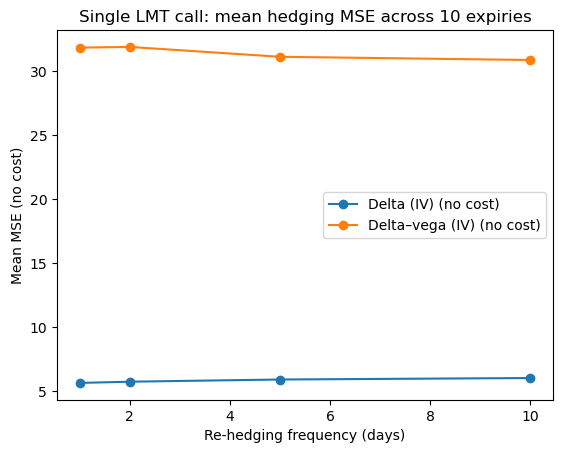

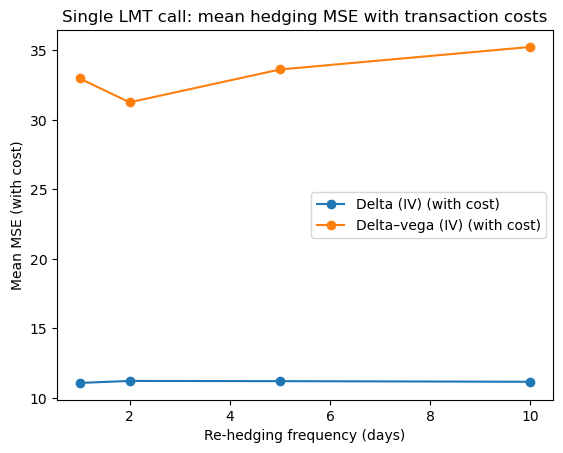

In [28]:

stats_reset = stats.reset_index()

fig, ax = plt.subplots()
for strat in stats_reset["strategy"].unique():
    sub = stats_reset[stats_reset["strategy"] == strat]
    ax.plot(
        sub["rebalance_every"],
        sub[("E_no_cost", "mean")],
        marker="o",
        label=f"{strat} (no cost)",
    )
ax.set_xlabel("Re-hedging frequency (days)")
ax.set_ylabel("Mean MSE (no cost)")
ax.set_title("Single LMT call: mean hedging MSE across 10 expiries")
ax.legend()
plt.show()

fig, ax = plt.subplots()
for strat in stats_reset["strategy"].unique():
    sub = stats_reset[stats_reset["strategy"] == strat]
    ax.plot(
        sub["rebalance_every"],
        sub[("E_with_cost", "mean")],
        marker="o",
        label=f"{strat} (with cost)",
    )
ax.set_xlabel("Re-hedging frequency (days)")
ax.set_ylabel("Mean MSE (with cost)")
ax.set_title("Single LMT call: mean hedging MSE with transaction costs")
ax.legend()
plt.show()



Butterfly portfolio: delta vs delta–vega across frequencies
   rebalance_every         strategy   E_no_cost  E_with_cost  total_cost  \
0                1       Delta only  142.076646   140.861707    2.066198   
1                1  Delta–vega (IV)  139.973006   138.659863    2.540009   
2                2       Delta only  141.620602   140.188003    1.991331   
3                2  Delta–vega (IV)  140.416304   138.697097    2.524768   
4                5       Delta only  141.367049   141.277463    0.123796   
5                5  Delta–vega (IV)  140.682842   140.812410    0.595126   
6               10       Delta only  140.994342   141.004511    0.007966   
7               10  Delta–vega (IV)  140.961521   141.337775    0.288097   

   sqrt_E_no_cost  sqrt_E_with_cost  
0       11.919591         11.868517  
1       11.831019         11.775392  
2       11.900445         11.840101  
3       11.849739         11.776973  
4       11.889788         11.886020  
5       11.860980         

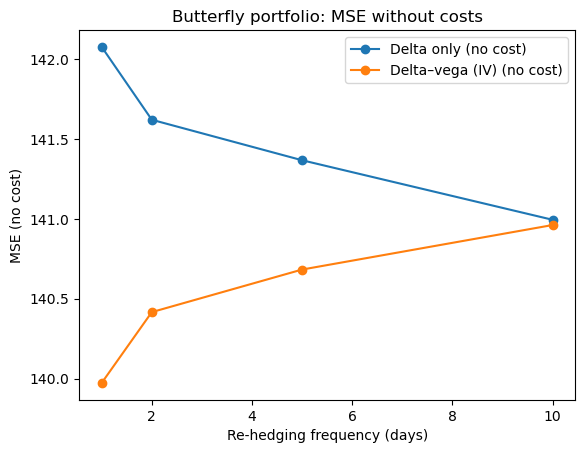

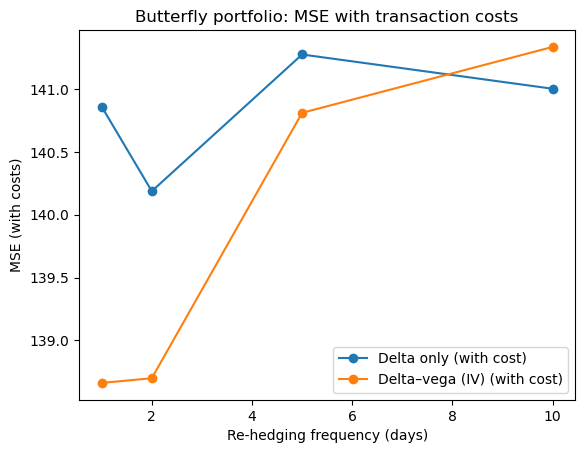

In [32]:
# --- Butterfly delta vs delta-vega comparison ---

df_bfly_summary = df_bfly_compare.copy()
df_bfly_summary["sqrt_E_no_cost"] = np.sqrt(df_bfly_summary["E_no_cost"])
df_bfly_summary["sqrt_E_with_cost"] = np.sqrt(df_bfly_summary["E_with_cost"])

print("\nButterfly portfolio: delta vs delta–vega across frequencies")
print(df_bfly_summary)

fig, ax = plt.subplots()
for strat in df_bfly_summary["strategy"].unique():
    sub = df_bfly_summary[df_bfly_summary["strategy"] == strat]
    ax.plot(
        sub["rebalance_every"],
        sub["E_no_cost"],
        marker="o",
        label=f"{strat} (no cost)",
    )
ax.set_xlabel("Re-hedging frequency (days)")
ax.set_ylabel("MSE (no cost)")
ax.set_title("Butterfly portfolio: MSE without costs")
ax.legend()
plt.show()

fig, ax = plt.subplots()
for strat in df_bfly_summary["strategy"].unique():
    sub = df_bfly_summary[df_bfly_summary["strategy"] == strat]
    ax.plot(
        sub["rebalance_every"],
        sub["E_with_cost"],
        marker="o",
        label=f"{strat} (with cost)",
    )
ax.set_xlabel("Re-hedging frequency (days)")
ax.set_ylabel("MSE (with costs)")
ax.set_title("Butterfly portfolio: MSE with transaction costs")
ax.legend()
plt.show()

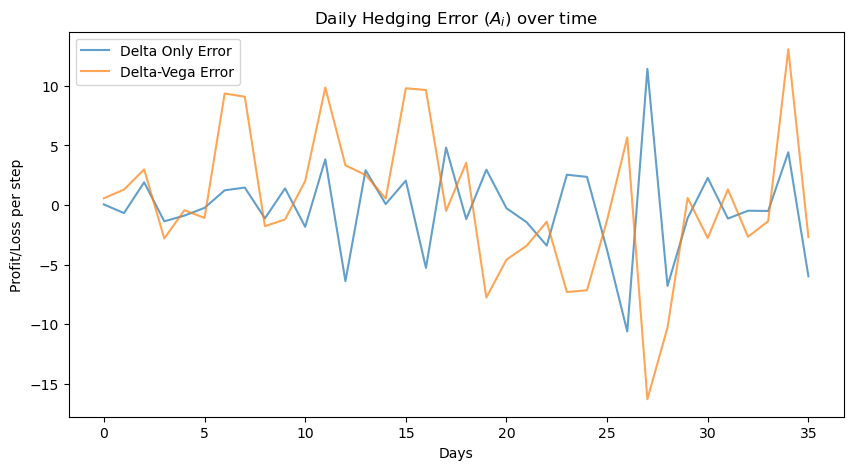

In [33]:
# Results from the Daily (1-day) run for the first expiry
res_d = results[1]      # single-run delta result
res_dv = res_dv_iv      # single-run delta-vega result

plt.figure(figsize=(10, 5))
plt.plot(res_d['A_no_cost'], label='Delta Only Error', alpha=0.7)
plt.plot(res_dv['A_no_cost'], label='Delta-Vega Error', alpha=0.7)
plt.title("Daily Hedging Error ($A_i$) over time")
plt.ylabel("Profit/Loss per step")
plt.xlabel("Days")
plt.legend()
plt.show()